## Analyzing Extreme Precipitation Events in Bloomington Using Generalized Extreme Value Regression

### *Sets up*

`gevfunctions`: This module contains various functions related to the Generalized Extreme Value (GEV) distribution. It is a custom module designed for fitting and analyzing GEV distributions.

`maxlikelihood`: This module provides functionality for maximum likelihood estimation. It is custom-made for performing maximum likelihood calculations on various statistical data.


In [34]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import sys
sys.path.append('../G577-homework3/')
import gevfunctions as gevf
import maxlikelihood as max_like

#### Read the 2-day maximum precipitation data for Bloomington

In [35]:
df = pd.read_csv('/home/data/bloomington_rx2day.csv')

In [36]:
df

,#Year,Rx2day [in]
0,1895,2.200787
1,1896,2.677165
2,1897,5.889764
3,1898,2.578740
4,1899,2.610236
...,...,...
122,2018,5.137795
123,2019,3.740157
124,2020,3.578740
125,2021,6.098425


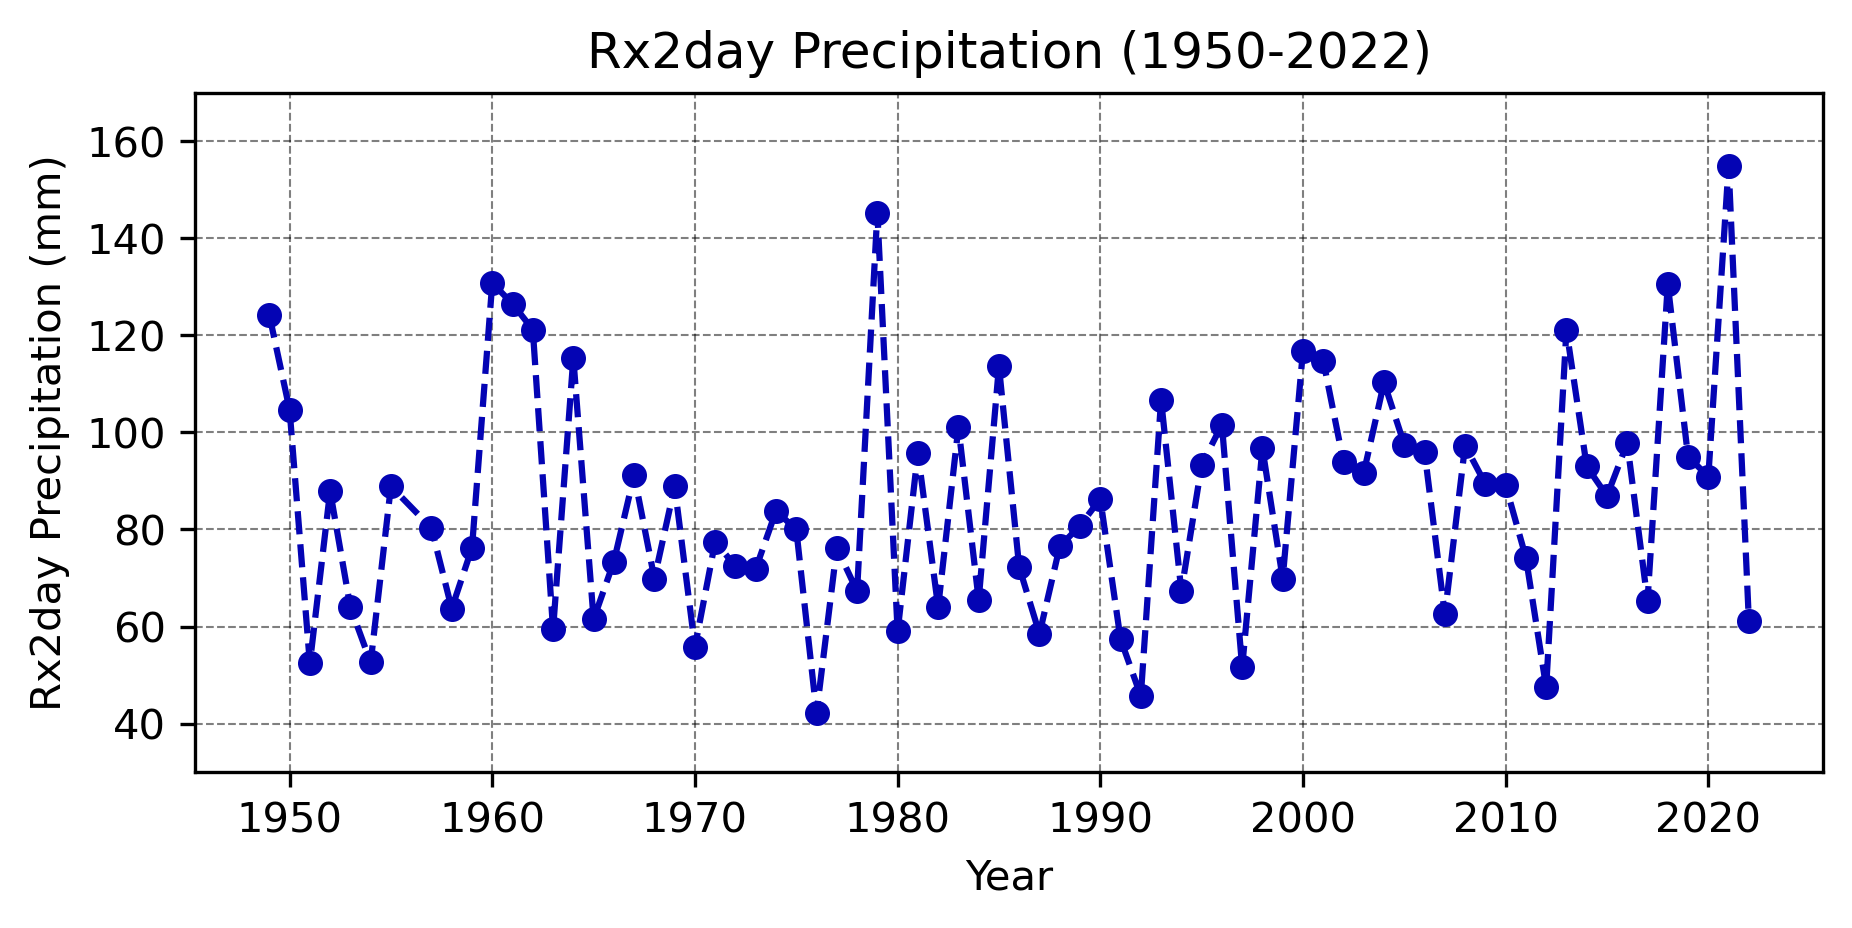

In [37]:
time = df['#Year'][54:].values
prec = df['Rx2day [in]'][54:].values * 25.4  # Convert [in] to [mm]

fig, ax = plt.subplots(1, 1, figsize=(7, 3), dpi=300)

ax.plot(time, prec, marker='o', color='#0404b4', linestyle='--', linewidth=1.5, markersize=5)

# Adding labels, title, and grid
ax.set_title('Rx2day Precipitation (1950-2022)')
ax.set_xlabel('Year')
ax.set_ylabel('Rx2day Precipitation (mm)')
ax.set_ylim(30, 170)  # Setting y-axis range
ax.set_xticks(np.arange(1950, 2023, 10))  # Setting x-axis ticks every 10 years
ax.grid(linestyle='--', linewidth=0.5, alpha=0.5, color='k')

# Display the plot
plt.show()


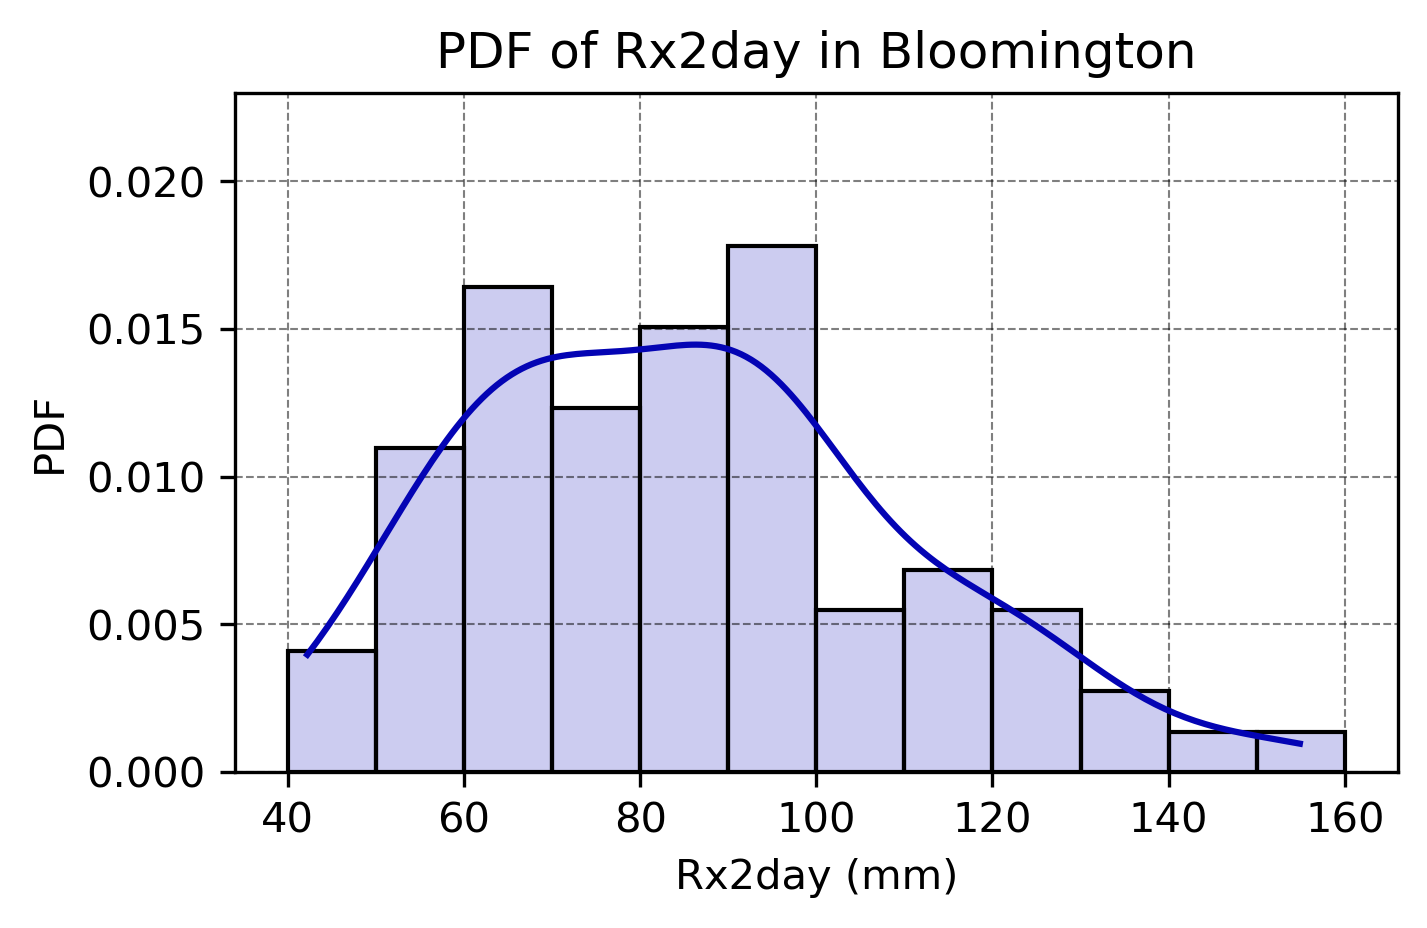

In [38]:
prec = df['Rx2day [in]'][54:].values * 25.4

fig, ax = plt.subplots(1, 1, figsize=(5, 3), dpi=300)
bins = [40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, ]
sns.histplot(prec, kde=True, color='#0404b4', bins=bins, alpha=0.2, stat='density')
ax.grid(linestyle='--', linewidth=0.5, alpha=0.5, color='k')
ax.set_title('PDF of Rx2day in Bloomington')
ax.set_xlabel('Rx2day (mm)')
ax.set_ylabel('PDF') 
ax.set_xticks(bins[::2])
ax.set_yticks([0.000, 0.005, 0.010, 0.015, 0.020])
ax.set_ylim(0, 0.023)

plt.show()


#### Use GEV regression to analyze Rx2day precipitation from 1950 to 2022.

In [39]:
time = df['#Year'][55:].values
prec = df['Rx2day [in]'][55:].values * 25.4  # Convert [in] to [mm]

param0 = [3, np.mean(prec), np.std(prec), 0.1]  # [cmu, mu0, sigma, xi] 
bounds = [(-1, 1), (None, None), (1e-3, None), (-0.5, 0.5)]  # bounds for [cmu, mu0, sigma, xi] 

# Run the maximum likelihood estimation
neg_log_lik, param_estimates = max_like.gev_ns_mle(prec, time-1950, param0, bounds)

In [40]:
# Print the results
print("Negative Log-Likelihood:", neg_log_lik)
print("Fitted GEV Parameters:")
print("cmu =", param_estimates[0])
print("mu0 =", param_estimates[1])
print("sigma =", param_estimates[2])
print("xi =", param_estimates[3])

Negative Log-Likelihood: 327.22544020952097
Fitted GEV Parameters:
cmu = 0.18469546966227848
mu0 = 68.24007538594701
sigma = 20.545964338824376
xi = -0.1021722296545198


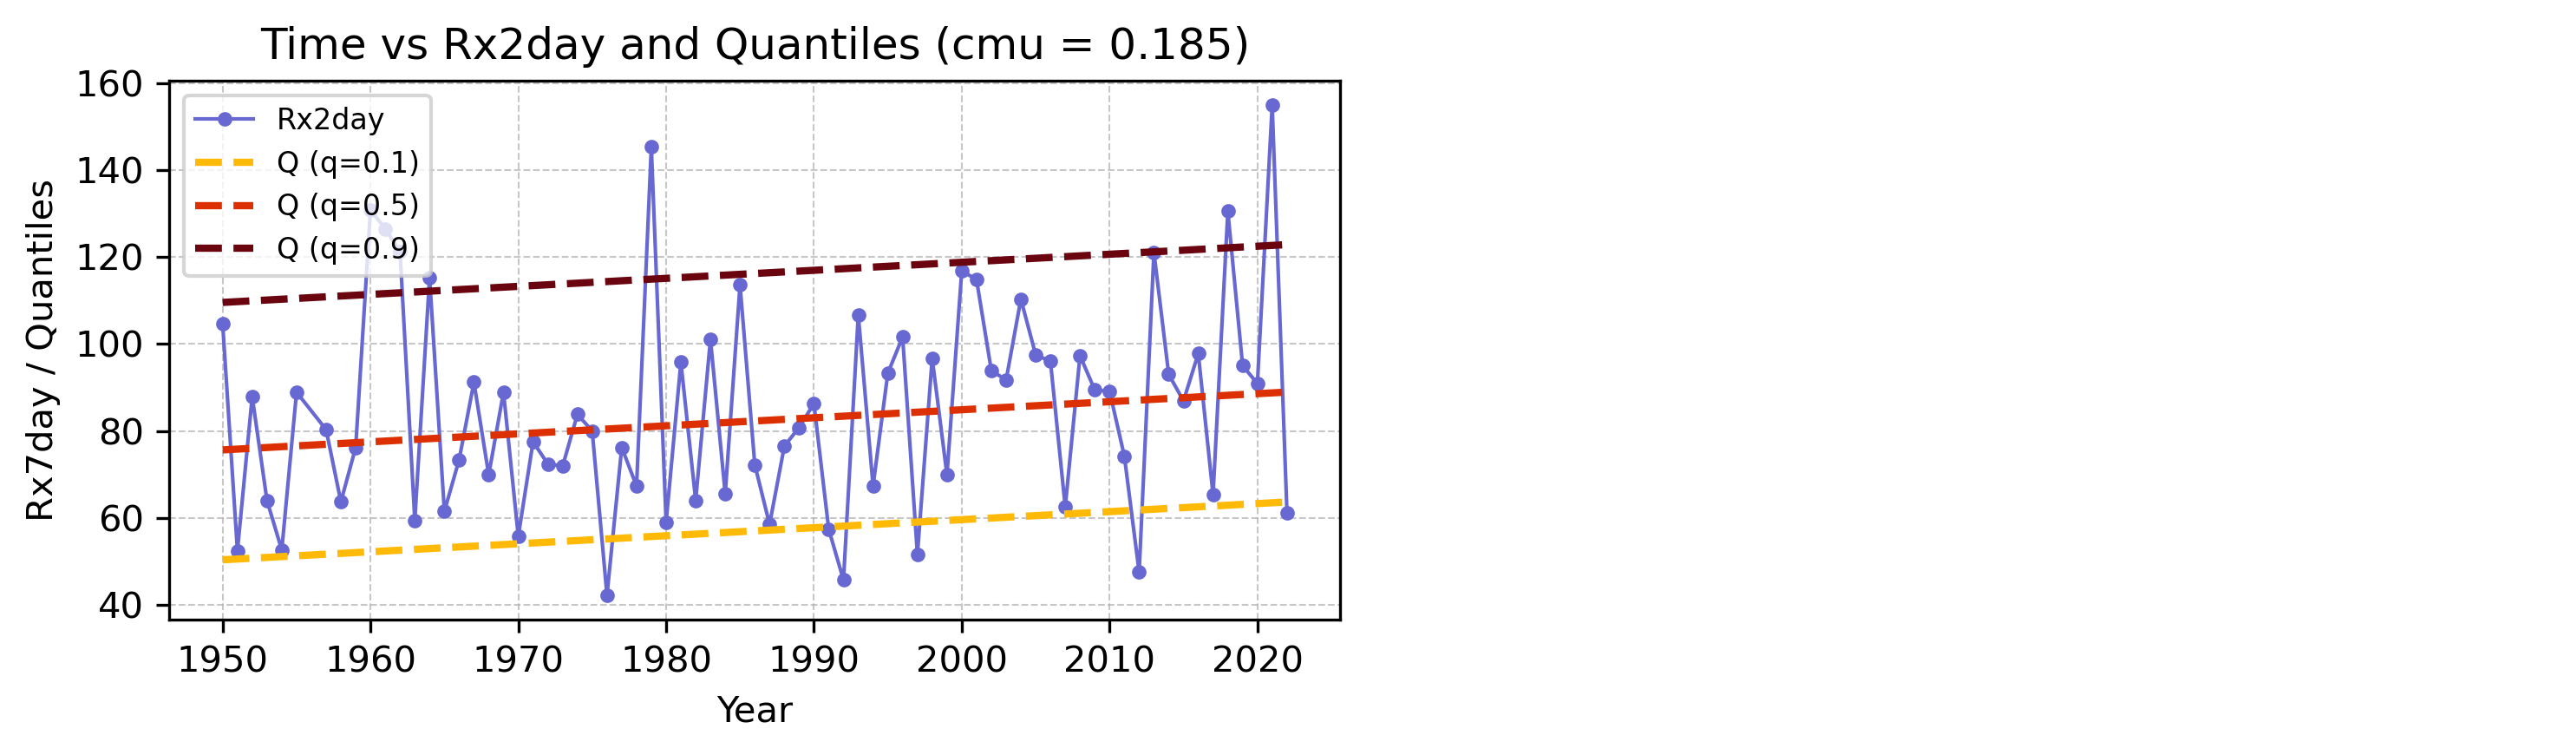

In [41]:
t = time-1950
q_values = [0.1, 0.5, 0.9] 

quantiles = {q: gevf.gev_ns_quantile(q, t, param_estimates[0], param_estimates[1], param_estimates[2], param_estimates[3]) for q in q_values} # Calculate quantiles

fig, ax = plt.subplots(1, 2, figsize=(10, 3), dpi=300) 
ax[0].plot(t, prec, label="Rx2day", color='#6868d2', marker='o',ms=3,lw=1, linestyle='-')

colors = ['#ffba08', '#dc2f02', '#6a040f']
for i, q in enumerate(q_values):
    ax[0].plot(t, quantiles[q], label=f"Q (q={q})", color=colors[i],lw=2, linestyle='--')

ax[0].set_title(f"Time vs Rx2day and Quantiles (cmu = {param_estimates[0]:.3f})")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Rx7day / Quantiles")
ax[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax[0].set_xticks(np.arange(0, 75, 10))  
ax[0].set_xticklabels(np.arange(1950, 2025, 10))  
ax[0].legend(loc=2, prop={'size': 8})
ax[1].axis('off')
plt.tight_layout()
plt.show()

#### Estimates the return interval of the event in 2021

**Non-stationary Location Parameter**

The location parameter μ(t) of the GEV distribution can change over time, represented as:
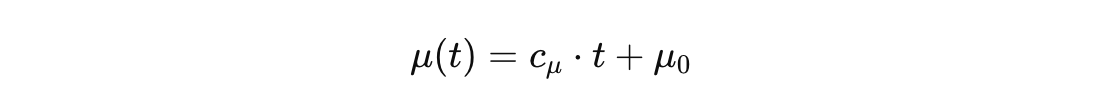
where cμ is the coefficient indicating how the location parameter changes per unit time, and μ0 is the baseline location parameter.

**Non-stationary GEV CDF**

The CDF for the non-stationary GEV, incorporating a time-varying location parameter, is formulated as:
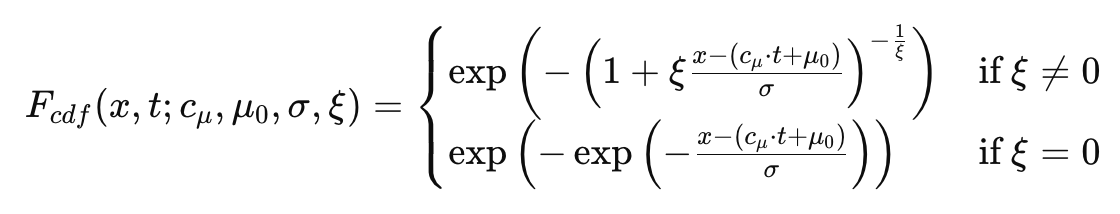
**Survival Function**

The survival function S(x;t) is then the complement of the CDF, representing the probability that the observed value exceeds a specific value x at time t. It is computed as:
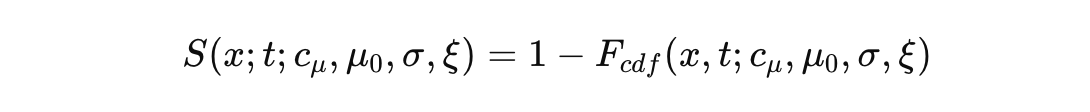
This function quantifies the probability that a random variable from a non-stationary GEV distribution with a time-dependent location parameter will exceed the value x at time t. Such calculations are pivotal in fields like hydrology, meteorology, and other areas where assessing risks associated with extreme values is crucial.

In [42]:
# Extract parameters
cmu, mu0, sigma, xi = param_estimates

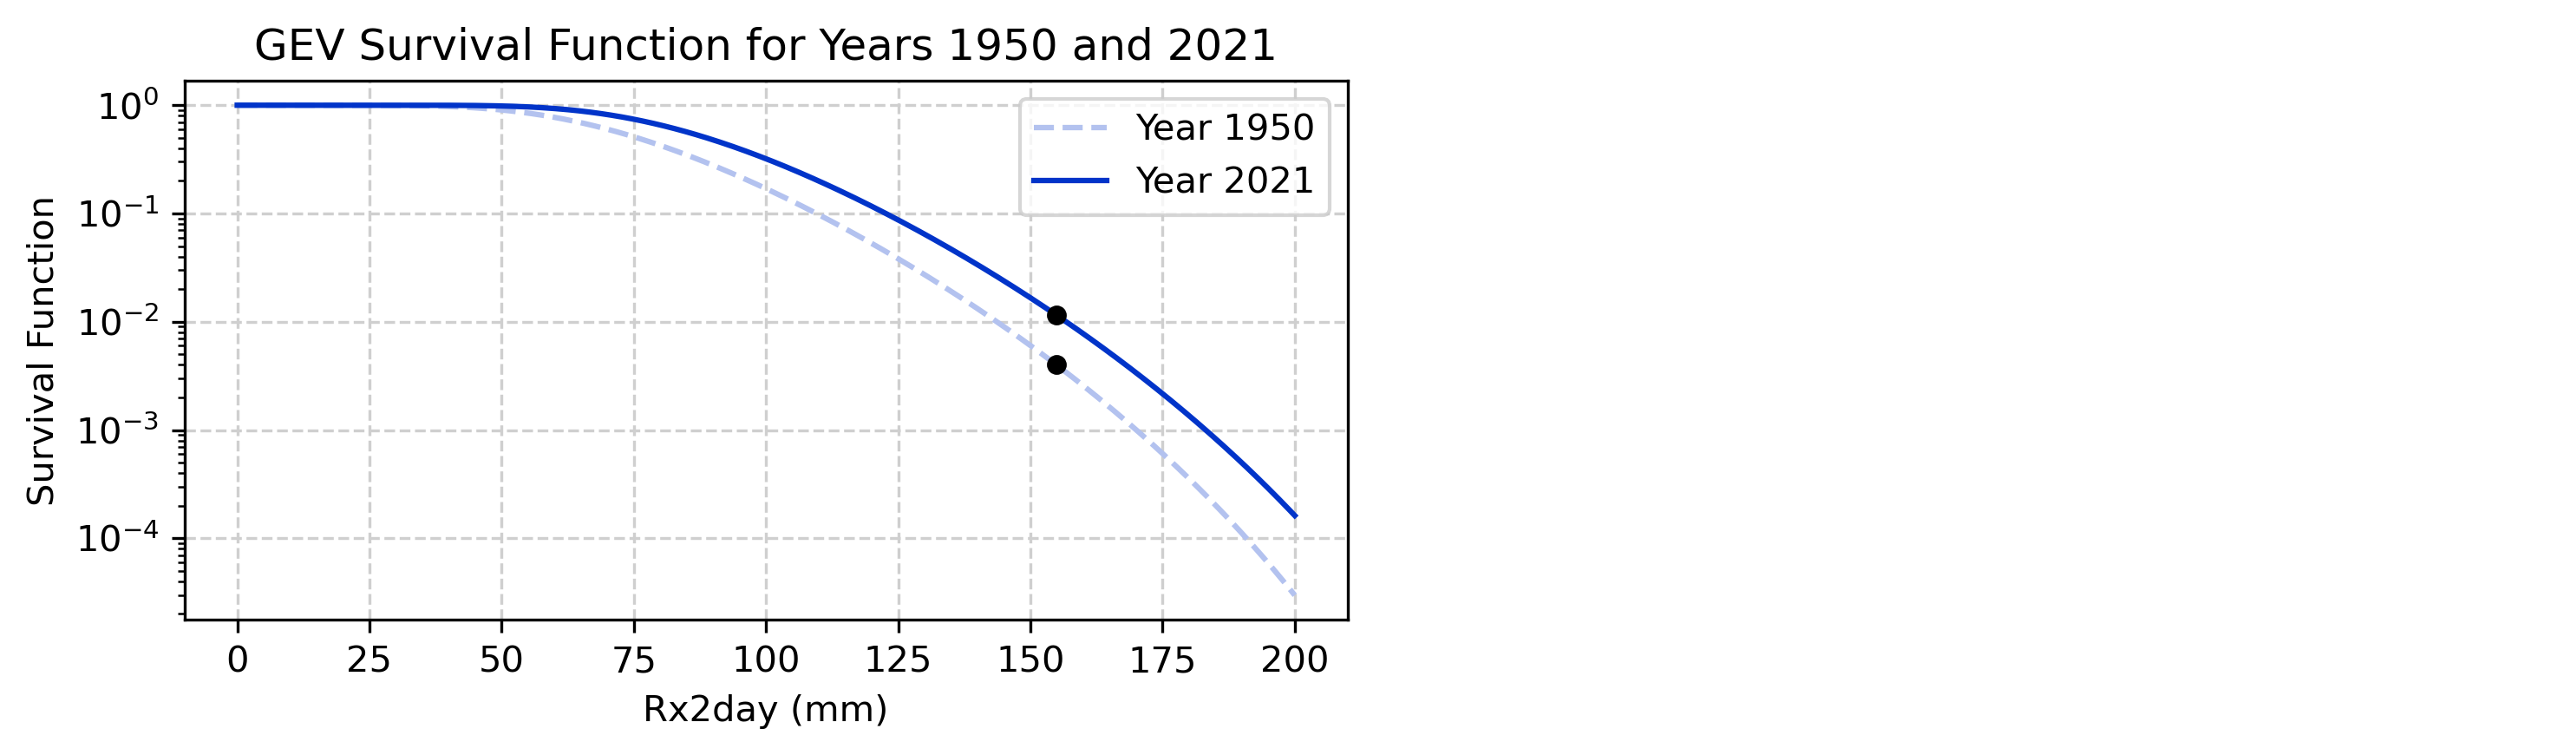

In [43]:
thresholds = np.linspace(0, 200, 400)
cdf_values_2021 = gevf.gev_ns_cdf(thresholds, xi=xi, cmu=cmu, mu0=mu0, sigma=sigma, t=71) # Calculate CDF
cdf_values_1950 = gevf.gev_ns_cdf(thresholds, xi=xi, cmu=cmu, mu0=mu0, sigma=sigma, t=0)

sf_values_2021 = 1 - cdf_values_2021  # Calculate survival functions
sf_values_1950 = 1 - cdf_values_1950


fig, ax = plt.subplots(1, 2, figsize=(10, 3), dpi=300)

ax[0].plot(thresholds, sf_values_1950, color='#b3c2ef', label='Year 1950', ls='--')# Plot survival functions for years 1950 and 2021
ax[0].plot(thresholds, sf_values_2021, color='#0134c9', label='Year 2021')


x_point_1950 = thresholds[309] # Add scatter points at Rx2day = 154.9
x_point_2021 = thresholds[309]
y_point_1950 = sf_values_1950[309]
y_point_2021 = sf_values_2021[309]
ax[0].scatter(x_point_1950, y_point_1950, color='k', s=20, zorder=2)  
ax[0].scatter(x_point_2021, y_point_2021, color='k', s=20, zorder=2) 

ax[0].set_title('GEV Survival Function for Years 1950 and 2021')
ax[0].set_xlabel('Rx2day (mm)')
ax[0].set_ylabel('Survival Function')
ax[0].set_yscale('log')

ax[0].grid(True, which='major', linestyle='--', color='#cfcfcf')
ax[0].legend()
ax[1].axis('off')
plt.tight_layout()
plt.show()


#### Estimates the return interval and risk ratio 

**Return Interval (Return Perids)**

A return period, also known as a recurrence interval, is an estimate of the interval of time between events like floods, storms, or other natural hazards of a certain size or intensity. It is commonly used in risk assessment and planning, to gauge how often an event of a particular extremity is expected to recur.

**Calculation**

Given a survival function S(x), which represents the probability that an event larger than x occurs, the return period T for an event exceeding a threshold x can be calculated as the inverse of the survival function evaluated at x:
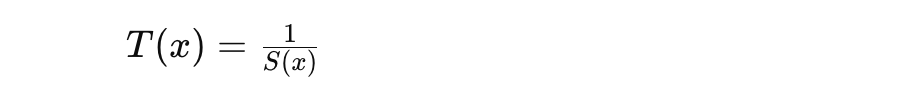
Where:
T(x) is the return period, or the expected number of years between events exceeding the threshold x.
S(x) is the survival function, which is the probability that an event exceeds x.

**Risk Ratio**
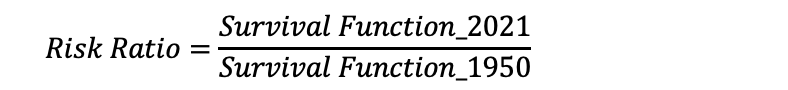
The survival_functions_2021 and survival_functions_1950 represent the probabilities of occurrenceof an such event in the year 2021 and 1950, respectively.

In [44]:
Rx2day = 154.9  # thresholds[309] = 154.88 
return_periods_1950 = 1 / (sf_values_1950[309])
return_periods_2021 = 1 / (sf_values_2021[309])

print(f'Return period for the observed Rx2day from Bloomington extreme precipitation event in 2021: {return_periods_2021:.2f}')
print(f'Return period for the observed Rx2day from Bloomington extreme precipitation event in 1950: {return_periods_1950:.2f}')


Return period for the observed Rx2day from Bloomington extreme precipitation event in 2021: 86.57
Return period for the observed Rx2day from Bloomington extreme precipitation event in 1950: 249.36


In [45]:
risk_ratio = sf_values_2021[309]/sf_values_1950[309]
print(f'The risk ratio of extreme precipitation events occurring in 2021 compared to 1950: {risk_ratio:.2f}')

The risk ratio of extreme precipitation events occurring in 2021 compared to 1950: 2.88


In [46]:
years = np.arange(1950, 2023)
return_periods = []

# Loop over each year and calculate the return interval
for year in years:
    # Calculate CDF for the current year's parameters at all thresholds
    cdf_values = gevf.gev_ns_cdf(thresholds, xi=xi, cmu=cmu, mu0=mu0, sigma=sigma, t=year - 1950)
    
    # Calculate the survival
    sf_values = 1 - cdf_values
    
    # Calculate the return period for the specific threshold
    return_period = 1 / sf_values[309]
    
    # Store the return period
    return_periods.append(return_period)

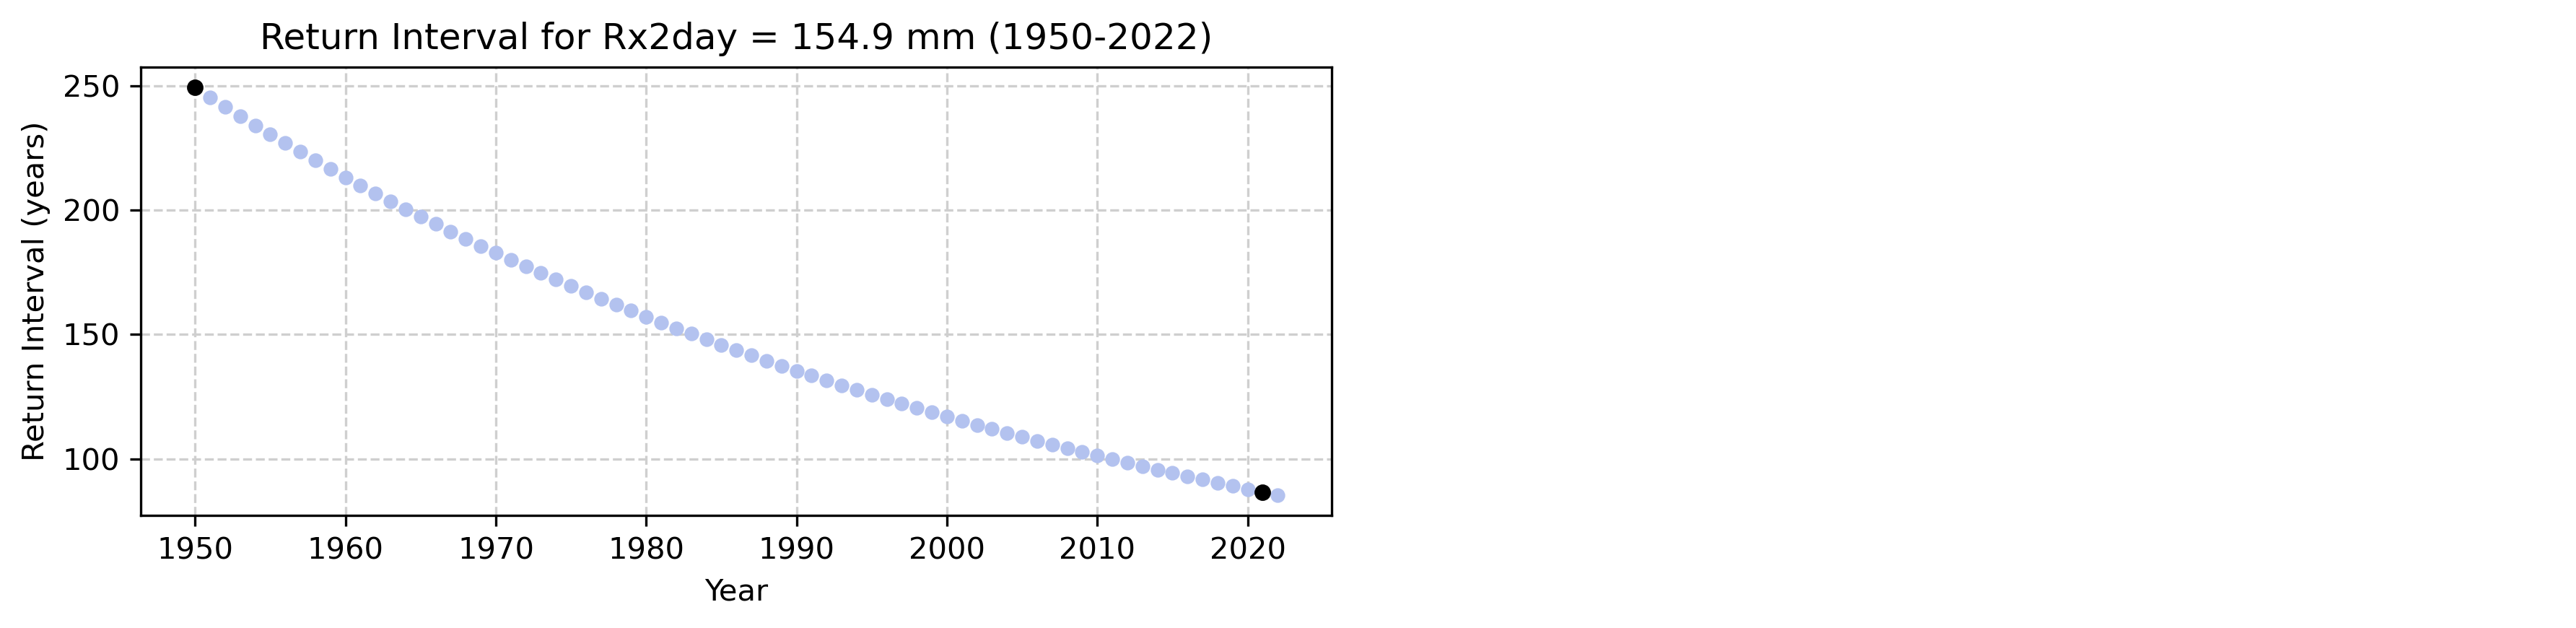

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3), dpi=300)

# ax[0].plot(t, return_periods, color='#b3c2ef', label='Year 1950', ls='--')# Plot survival functions for years 1950 and 2021

ax[0].scatter(years, return_periods, color='#b3c2ef', s=15, zorder=2) 
ax[0].scatter(years[0], return_periods[0], color='k', s=20, zorder=2)  
ax[0].scatter(years[-2], return_periods[-2], color='k', s=20, zorder=2) 
ax[0].set_title('Return Interval for Rx2day = 154.9 mm (1950-2022)')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Return Interval (years)')

ax[0].grid(True, which='major', linestyle='--', color='#cfcfcf')

ax[1].axis('off')
plt.tight_layout()
plt.show()

In [48]:
risk_ratio = sf_values_2021/sf_values_1950

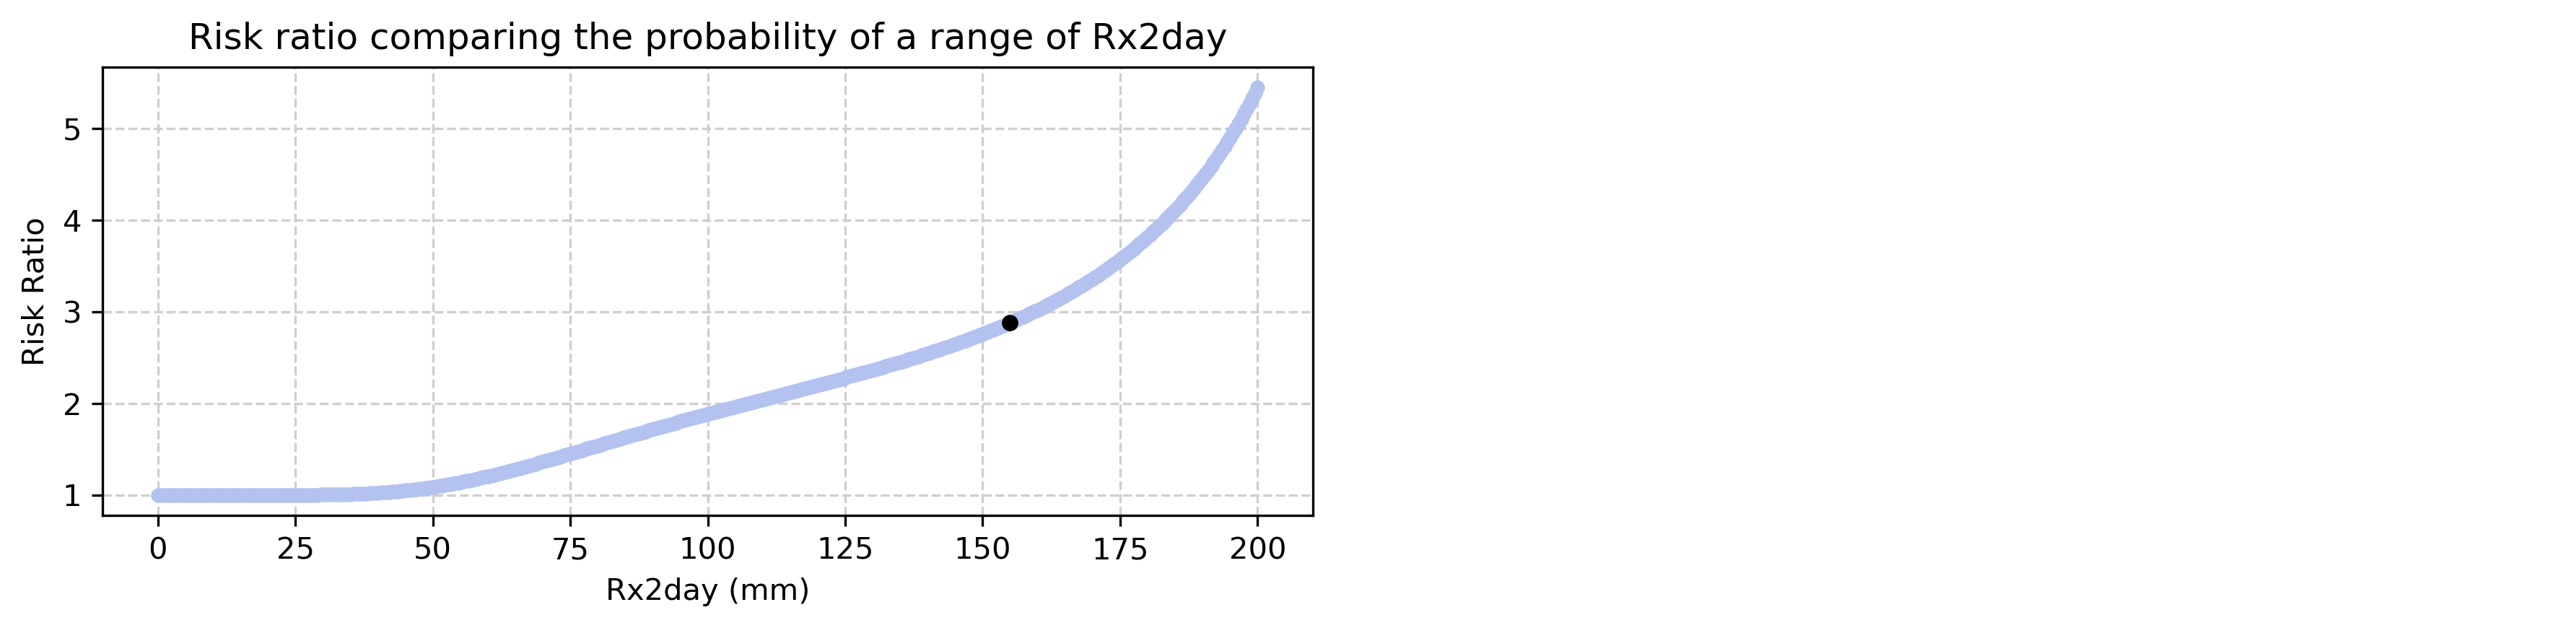

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3), dpi=300)

# ax[0].plot(t, return_periods, color='#b3c2ef', label='Year 1950', ls='--')# Plot survival functions for years 1950 and 2021

ax[0].scatter(thresholds, risk_ratio, color='#b3c2ef', s=15, zorder=2) 
ax[0].scatter(thresholds[309], risk_ratio[309], color='k', s=20, zorder=2) 
ax[0].set_title('Risk ratio comparing the probability of a range of Rx2day')
ax[0].set_xlabel('Rx2day (mm)')
ax[0].set_ylabel('Risk Ratio')

ax[0].grid(True, which='major', linestyle='--', color='#cfcfcf')

ax[1].axis('off')
plt.tight_layout()
plt.show()

### Appemdix

Comparing the results obtained using data from 1895 to 2022.

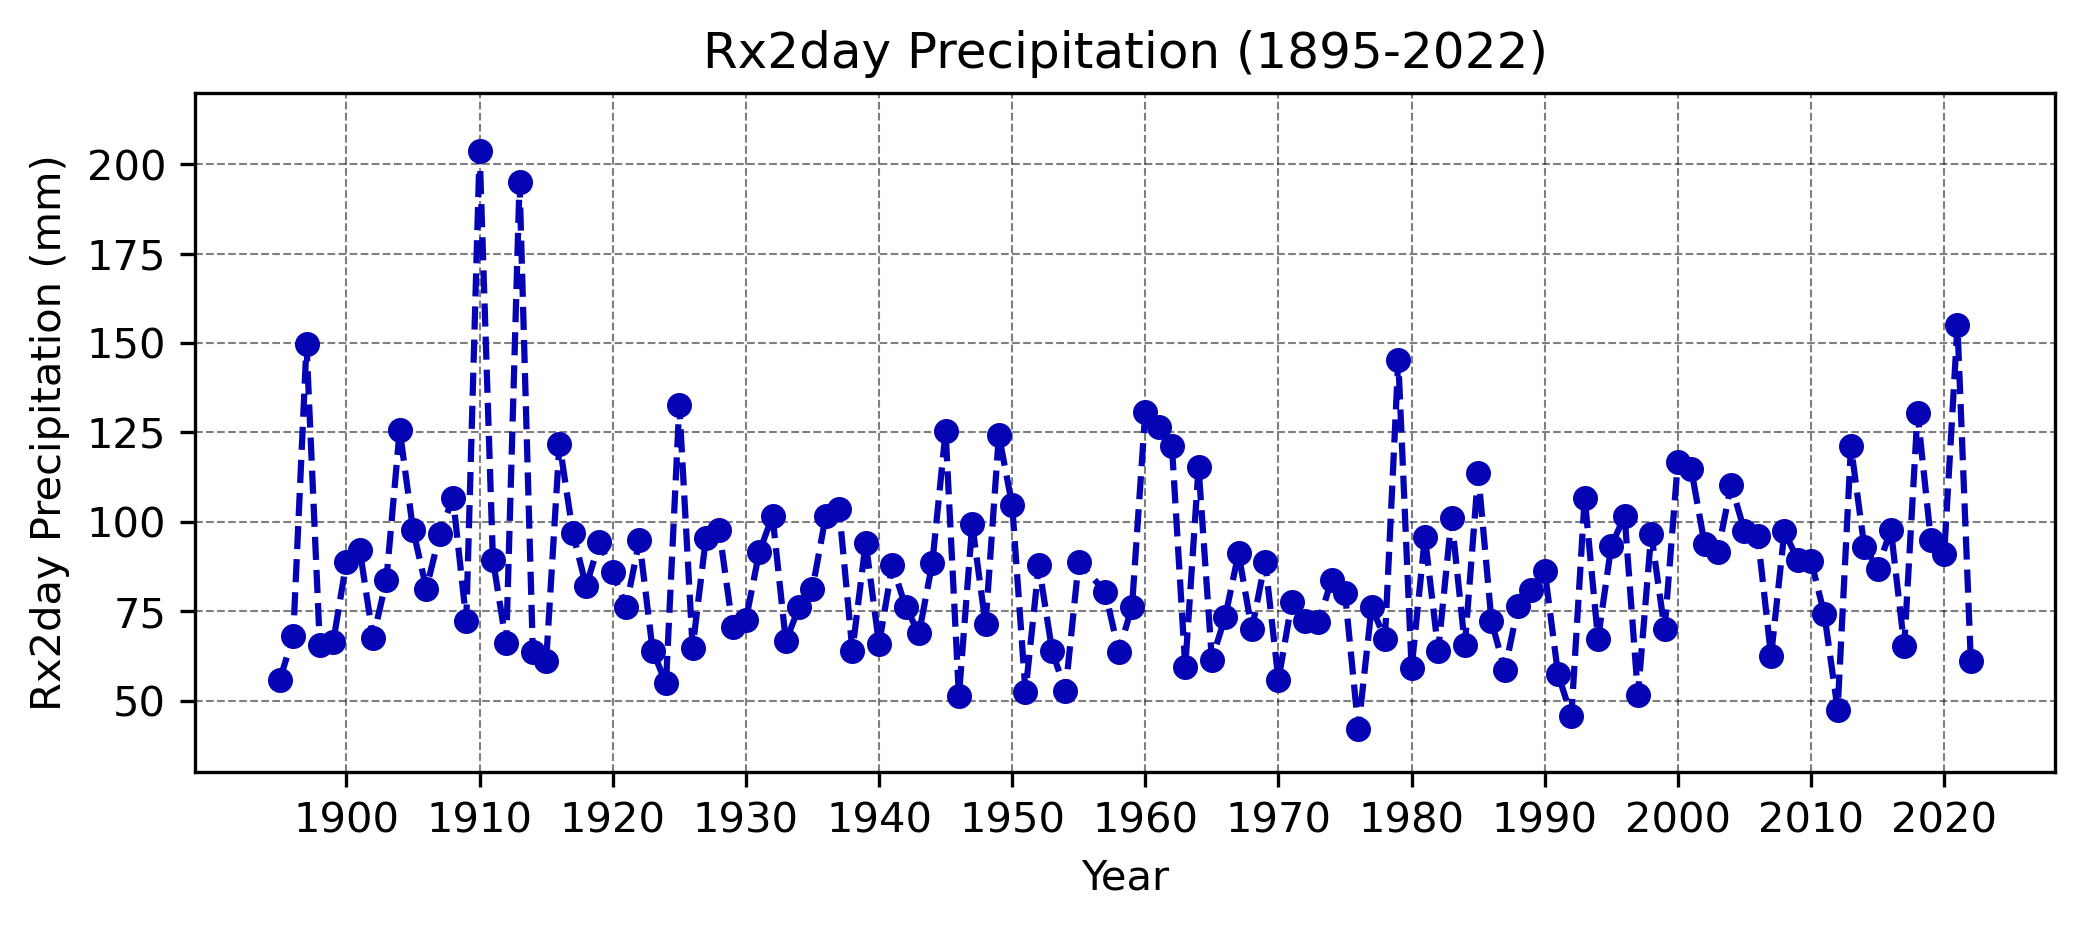

In [50]:
time = df['#Year'].values
prec = df['Rx2day [in]'].values * 25.4  # Convert [in] to [mm]

fig, ax = plt.subplots(1, 1, figsize=(8, 3), dpi=300)

ax.plot(time, prec, marker='o', color='#0404b4', linestyle='--', linewidth=1.5, markersize=5)

# Adding labels, title, and grid
ax.set_title('Rx2day Precipitation (1895-2022)')
ax.set_xlabel('Year')
ax.set_ylabel('Rx2day Precipitation (mm)')
ax.set_ylim(30, 220)  # Setting y-axis range
ax.set_xticks(np.arange(1900,2023, 10))  # Setting x-axis ticks every 10 years
ax.grid(linestyle='--', linewidth=0.5, alpha=0.5, color='k')

# Display the plot
plt.show()

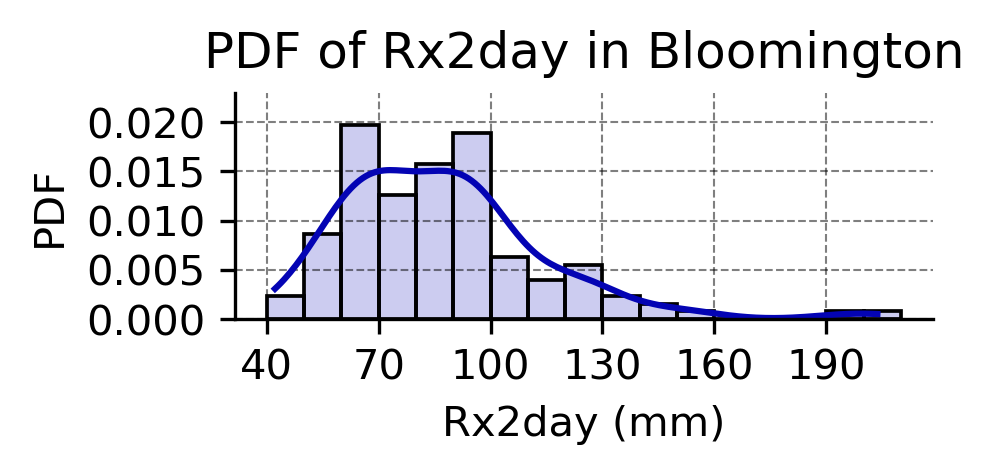

In [51]:
prec = df['Rx2day [in]'].values * 25.4

fig, ax = plt.subplots(1, 1, figsize=(3, 1), dpi=300)
bins = [ 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210]
sns.histplot(prec, kde=True, color='#0404b4', bins=bins, alpha=0.2, stat='density')
ax.grid(linestyle='--', linewidth=0.5, alpha=0.5, color='k')
ax.set_title('PDF of Rx2day in Bloomington')
ax.set_xlabel('Rx2day (mm)')
ax.set_ylabel('PDF') 
ax.set_xticks(bins[::3])
ax.set_yticks([0.000, 0.005, 0.010, 0.015, 0.020])
ax.set_ylim(0, 0.023)
# Hide the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

#### Use GEV regression to analyze Rx2day precipitation from 1895 to 2022.

In [52]:
time = df['#Year'].values
prec = df['Rx2day [in]'].values * 25.4  # Convert [in] to [mm]

param0 = [3, np.mean(prec), np.std(prec), 0.1]  # [cmu, mu0, sigma, xi] 
bounds = [(-1, 1), (None, None), (1e-3, None), (-0.5, 0.5)]  # bounds for [cmu, mu0, sigma, xi] 

# Run the maximum likelihood estimation
neg_log_lik, param_estimates = max_like.gev_ns_mle(prec, time-1895, param0, bounds)

In [53]:
# Print the results
print("Negative Log-Likelihood:", neg_log_lik)
print("Fitted GEV Parameters:")
print("cmu =", param_estimates[0])
print("mu0 =", param_estimates[1])
print("sigma =", param_estimates[2])
print("xi =", param_estimates[3])

Negative Log-Likelihood: 581.8531386944961
Fitted GEV Parameters:
cmu = -0.02292054036977287
mu0 = 76.28307658855636
sigma = 19.65757160819915
xi = 0.04055519783590676


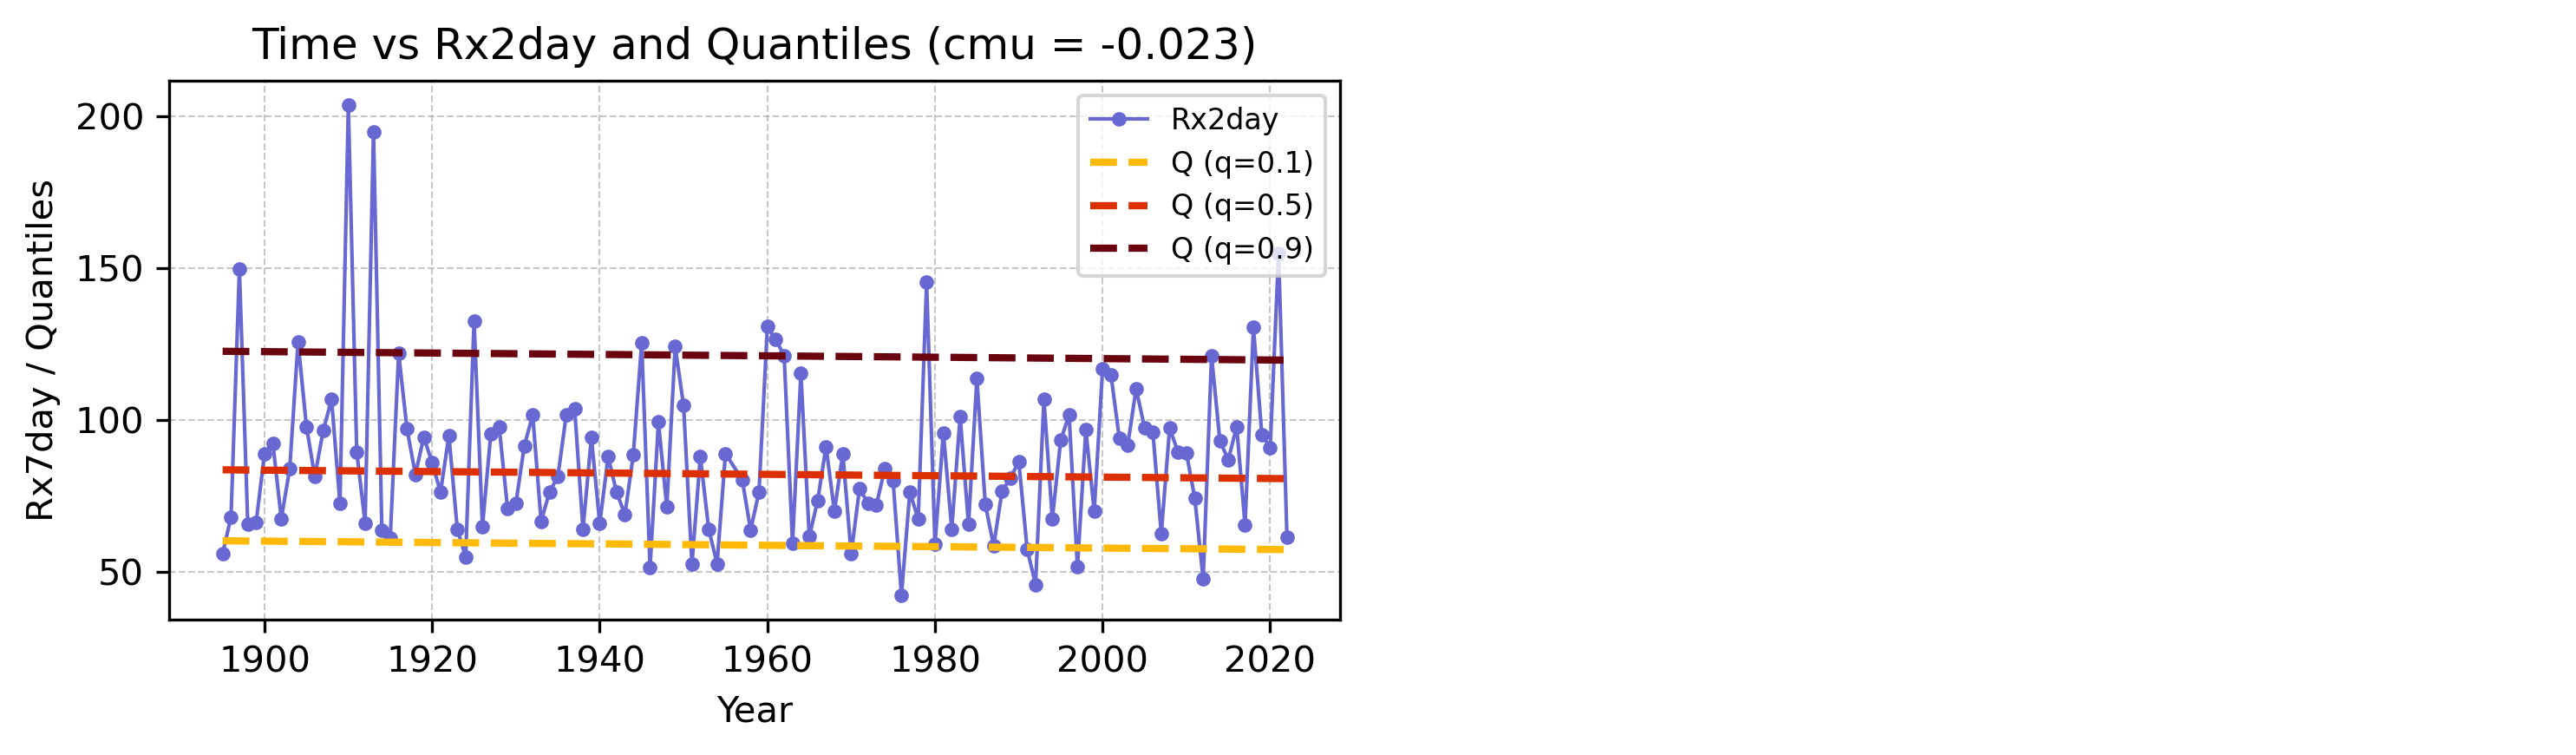

In [54]:
t = time-1895 # Converted to 0-66 years
q_values = [0.1, 0.5, 0.9] 

quantiles = {q: gevf.gev_ns_quantile(q, t, param_estimates[0], param_estimates[1], param_estimates[2], param_estimates[3]) for q in q_values} # Calculate quantiles

fig, ax = plt.subplots(1, 2, figsize=(10, 3), dpi=300) 
ax[0].plot(t, prec, label="Rx2day", color='#6868d2', marker='o',ms=3,lw=1, linestyle='-')

colors = ['#ffba08', '#dc2f02', '#6a040f']
for i, q in enumerate(q_values):
    ax[0].plot(t, quantiles[q], label=f"Q (q={q})", color=colors[i],lw=2, linestyle='--')

ax[0].set_title(f"Time vs Rx2day and Quantiles (cmu = {param_estimates[0]:.3f})")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Rx7day / Quantiles")
ax[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax[0].set_xticks(np.arange(5, 130, 20))  
ax[0].set_xticklabels(np.arange(1900, 2025, 20))  
ax[0].legend(loc=1, prop={'size': 8})
ax[1].axis('off')
plt.tight_layout()
plt.show()

In [55]:
# Extract parameters
cmu, mu0, sigma, xi = param_estimates

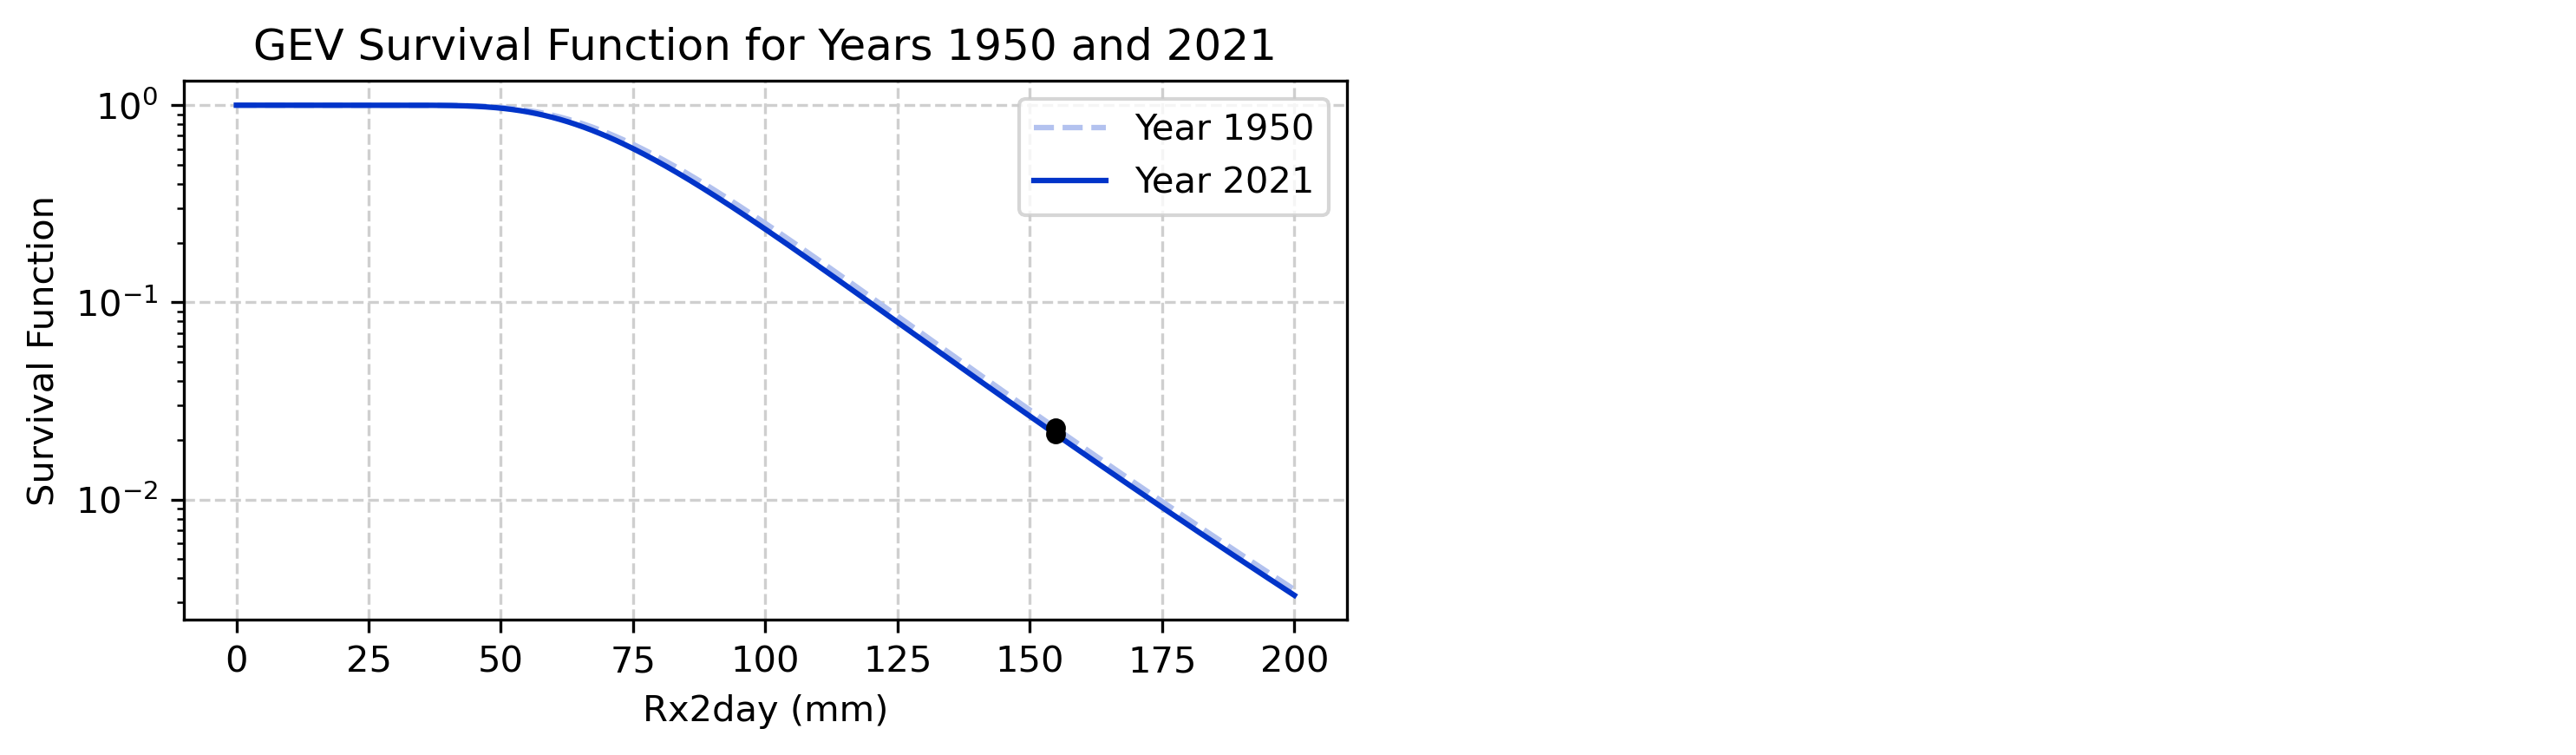

In [56]:
thresholds = np.linspace(0, 200, 400)
cdf_values_2021 = gevf.gev_ns_cdf(thresholds, xi=xi, cmu=cmu, mu0=mu0, sigma=sigma, t=126) # Calculate CDF
cdf_values_1950 = gevf.gev_ns_cdf(thresholds, xi=xi, cmu=cmu, mu0=mu0, sigma=sigma, t=55)

sf_values_2021 = 1 - cdf_values_2021  # Calculate survival functions
sf_values_1950 = 1 - cdf_values_1950


fig, ax = plt.subplots(1, 2, figsize=(10, 3), dpi=300)

ax[0].plot(thresholds, sf_values_1950, color='#b3c2ef', label='Year 1950', ls='--')# Plot survival functions for years 1950 and 2021
ax[0].plot(thresholds, sf_values_2021, color='#0134c9', label='Year 2021')


x_point_1950 = thresholds[309] # Add scatter points at Rx2day = 154.9
x_point_2021 = thresholds[309]
y_point_1950 = sf_values_1950[309]
y_point_2021 = sf_values_2021[309]
ax[0].scatter(x_point_1950, y_point_1950, color='k', s=20, zorder=2)  
ax[0].scatter(x_point_2021, y_point_2021, color='k', s=20, zorder=2) 

ax[0].set_title('GEV Survival Function for Years 1950 and 2021')
ax[0].set_xlabel('Rx2day (mm)')
ax[0].set_ylabel('Survival Function')
ax[0].set_yscale('log')

ax[0].grid(True, which='major', linestyle='--', color='#cfcfcf')
ax[0].legend()
ax[1].axis('off')
plt.tight_layout()
plt.show()



In [57]:
Rx2day = 154.9  # thresholds[309] = 154.88 
return_periods_1950 = 1 / (sf_values_1950[309])
return_periods_2021 = 1 / (sf_values_2021[309])

print(f'Return period for the observed Rx2day from Bloomington extreme precipitation event in 2021: {return_periods_2021:.2f}')
print(f'Return period for the observed Rx2day from Bloomington extreme precipitation event in 1950: {return_periods_1950:.2f}')


Return period for the observed Rx2day from Bloomington extreme precipitation event in 2021: 46.65
Return period for the observed Rx2day from Bloomington extreme precipitation event in 1950: 43.49


In [58]:
risk_ratio = sf_values_2021[309]/sf_values_1950[309]
print(f'The risk ratio of extreme precipitation events occurring in 2021 compared to 1950: {risk_ratio:.2f}')

The risk ratio of extreme precipitation events occurring in 2021 compared to 1950: 0.93


In [59]:
years = np.arange(1895, 2023)
return_periods = []

# Loop over each year and calculate the return interval
for year in years:
    # Calculate CDF for the current year's parameters at all thresholds
    cdf_values = gevf.gev_ns_cdf(thresholds, xi=xi, cmu=cmu, mu0=mu0, sigma=sigma, t=year - 1950)
    
    # Calculate the survival
    sf_values = 1 - cdf_values
    
    # Calculate the return period for the specific threshold
    return_period = 1 / sf_values[309]
    
    # Store the return period
    return_periods.append(return_period)

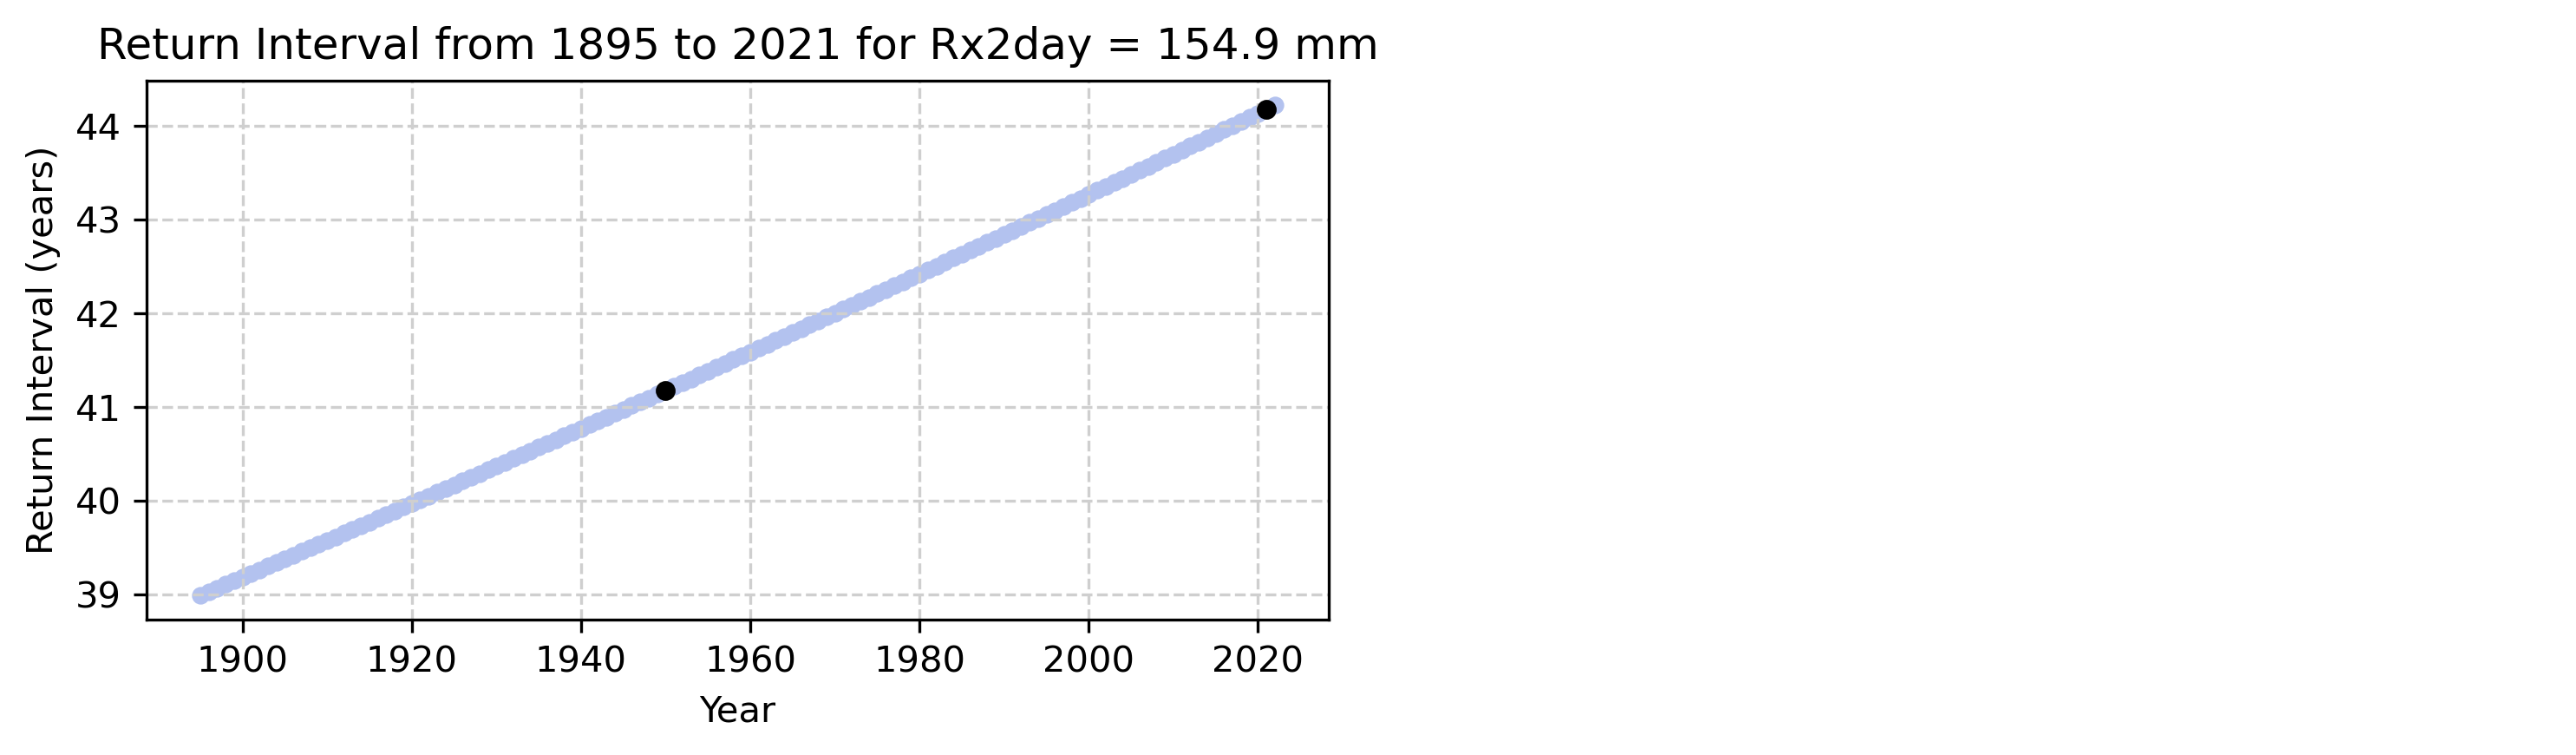

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), dpi=300)

# ax[0].plot(t, return_periods, color='#b3c2ef', label='Year 1950', ls='--')# Plot survival functions for years 1950 and 2021

ax[0].scatter(years, return_periods, color='#b3c2ef', s=15, zorder=1) 
ax[0].scatter(years[55], return_periods[55], color='k', s=20, zorder=2) 
ax[0].scatter(years[126], return_periods[126], color='k', s=20, zorder=2) 
ax[0].set_title('Return Interval from 1895 to 2021 for Rx2day = 154.9 mm')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Return Interval (years)')

ax[0].grid(True, which='major', linestyle='--', color='#cfcfcf')

ax[1].axis('off')
plt.tight_layout()
plt.show()

In [61]:
risk_ratio = sf_values_2021/sf_values_1950

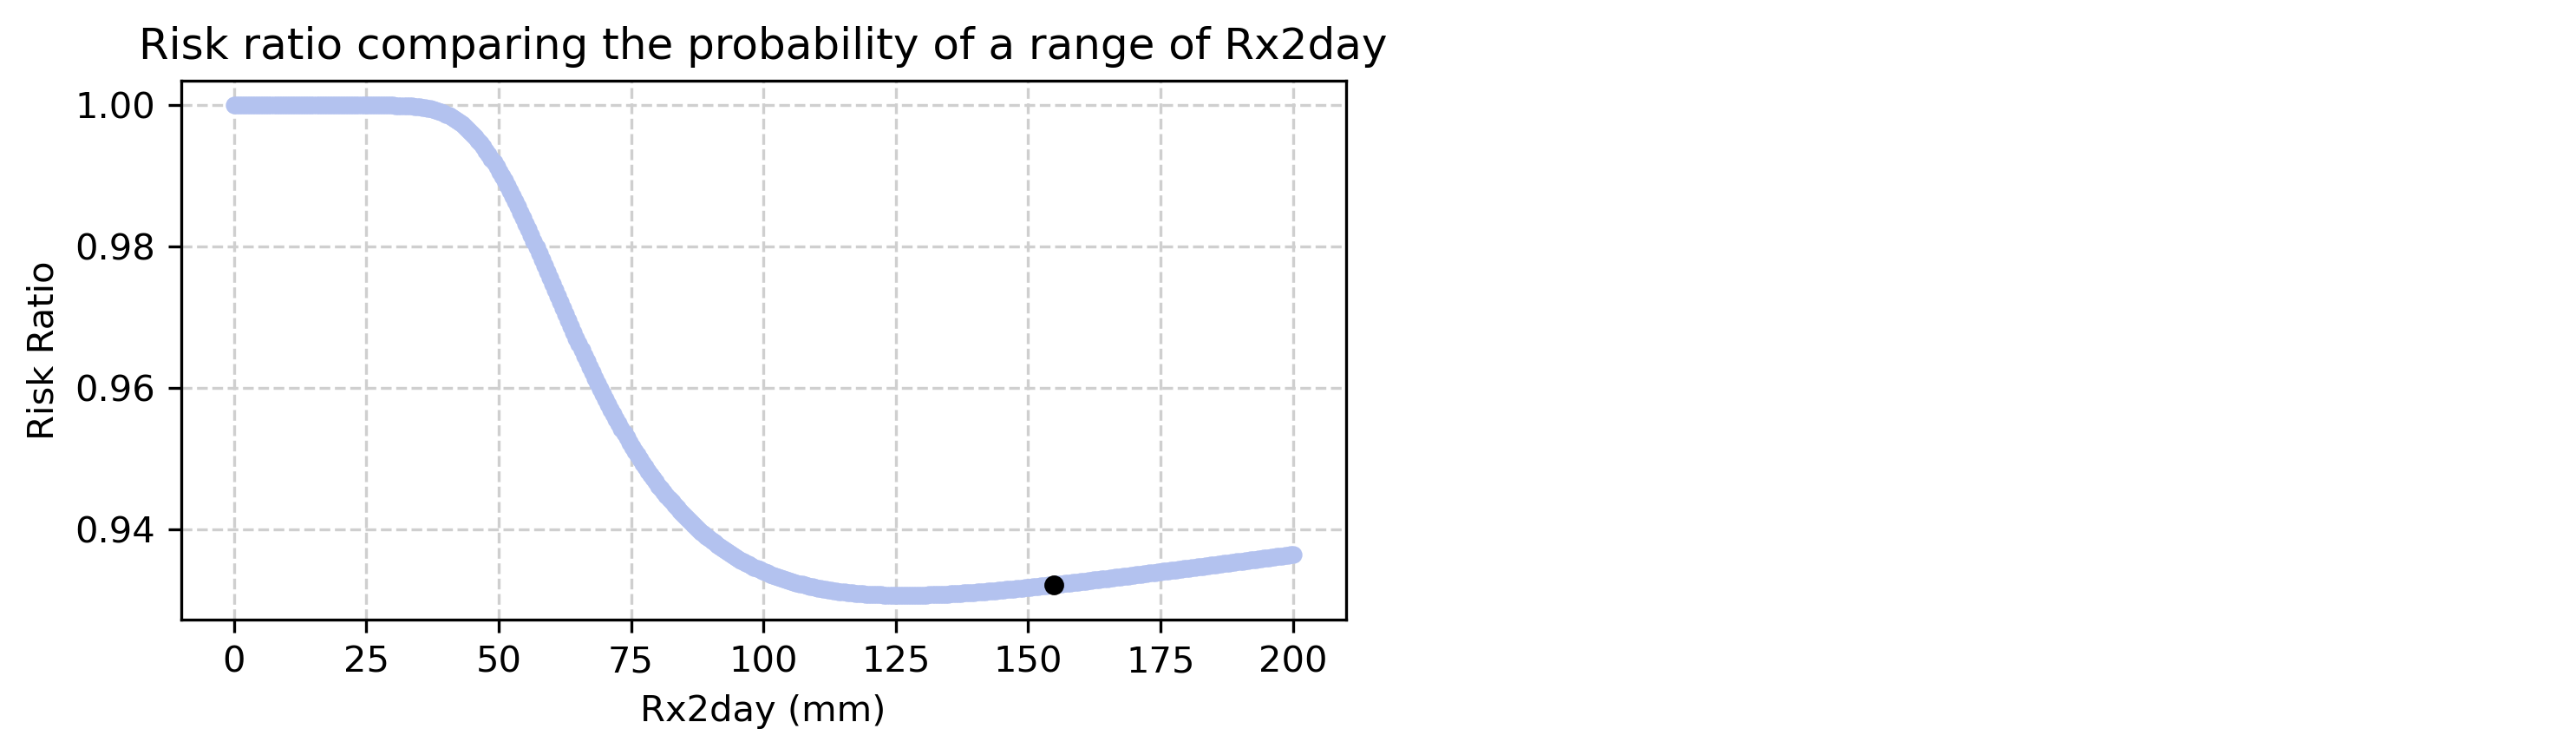

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), dpi=300)

# ax[0].plot(t, return_periods, color='#b3c2ef', label='Year 1950', ls='--')# Plot survival functions for years 1950 and 2021

ax[0].scatter(thresholds, risk_ratio, color='#b3c2ef', s=15, zorder=2) 
ax[0].scatter(thresholds[309], risk_ratio[309], color='k', s=20, zorder=2) 
ax[0].set_title('Risk ratio comparing the probability of a range of Rx2day')
ax[0].set_xlabel('Rx2day (mm)')
ax[0].set_ylabel('Risk Ratio')

ax[0].grid(True, which='major', linestyle='--', color='#cfcfcf')

ax[1].axis('off')
plt.tight_layout()
plt.show()